In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as f
import torch.optim as optim
import torchvision
from torchvision.transforms import v2
import random
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
dataset_path = "/kaggle/input/image-super-resolution/dataset"  #https://www.kaggle.com/datasets/adityachandrasekhar/image-super-resolution
train= dataset_path+"/train/"
val = dataset_path+ "/val/"
train_hires= train+ "high_res/"
train_lowres= train + "low_res/"

In [3]:
hiresimgs= os.listdir(train_hires)
lowresimgs= os.listdir(train_lowres)

len(hiresimgs), len(lowresimgs)

(685, 685)

(256, 256, 4) (256, 256, 4)


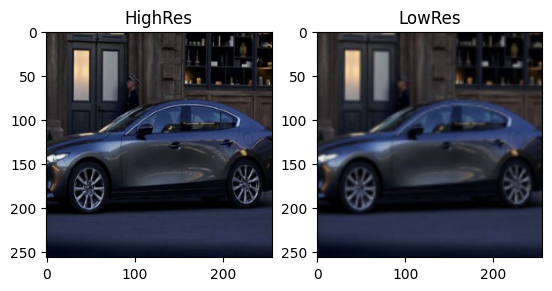

(256, 256, 4) (256, 256, 4)


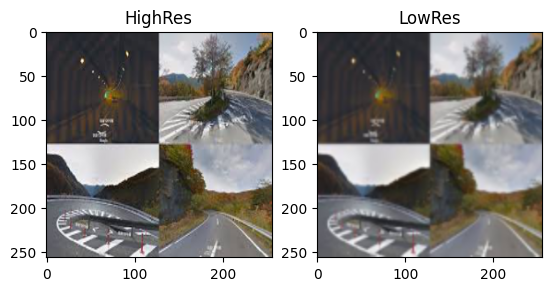

(256, 256, 4) (256, 256, 4)


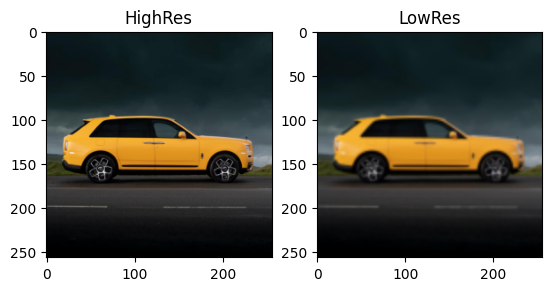

(256, 256, 4) (256, 256, 4)


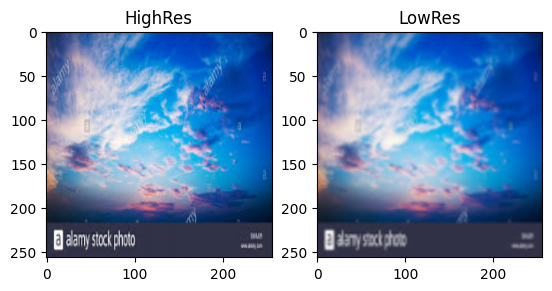

(256, 256, 4) (256, 256, 4)


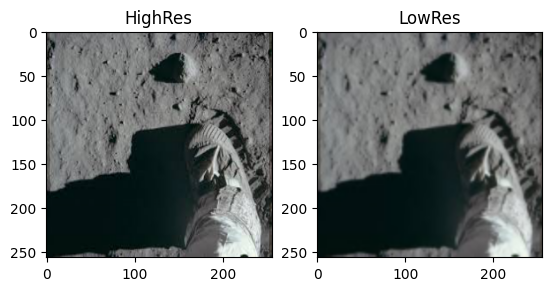

In [4]:
for i in range(5):
    hipath= train_hires+ hiresimgs[i]
    lowpath= train_lowres+ lowresimgs[i]
    
    hi= np.array(Image.open(hipath))
    lo= np.array(Image.open(lowpath))
    
    print(hi.shape, lo.shape)
    ax= plt.subplot(121)
    ax.imshow(hi)
    ax.set_title("HighRes")

    ax1= plt.subplot(122)
    ax1.imshow(lo)
    ax1.set_title("LowRes")

    plt.show()

In [5]:
hi.shape == (256, 256, 4) #whytf are there 4 channels

True

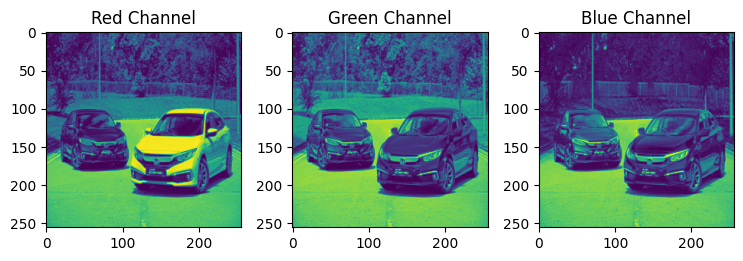

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the RGBA image
image_path = "/kaggle/input/image-super-resolution/dataset/train/high_res/0.png"  
image = Image.open(image_path).convert("RGB")

# Split the image into individual channels
r, g, b = image.split()

# Plot each channel separately
plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(r)
plt.title('Red Channel')

plt.subplot(1, 4, 2)
plt.imshow(g)
plt.title('Green Channel')

plt.subplot(1, 4, 3)
plt.imshow(b)
plt.title('Blue Channel')

# plt.subplot(1, 4, 4)
# plt.imshow(a)
# plt.title('Alpha Channel')

plt.tight_layout()
plt.show()


In [7]:
##checking all sizes

for i in range(len(train_hires)):
    
    hipath= train_hires+ hiresimgs[i]
    lowpath= train_lowres+ lowresimgs[i]
    
    hi= np.array(Image.open(hipath))
    lo= np.array(Image.open(lowpath))
    
    x,y=hi.shape,lo.shape 
    if x!=(256, 256, 4) or y!=(256, 256, 4):
        print(hipath, x.shape, lopath, y.shape)
    

In [9]:
class SRDataset(Dataset):
    def __init__(self, dataset_dir,mode="train", transforms=None):
        
        self.train = dataset_dir + f"/{mode}/"
        
        self.train_hires= self.train+ "high_res/"
        self.train_lowres= self.train + "low_res/"
                                      
        self.hiimgs = sorted(os.listdir(self.train_hires))
        self.lowimgs= sorted(os.listdir(self.train_lowres))
                                      
        self.tf= transforms

    def __len__(self):
        return len(self.hiimgs)

    def __getitem__(self, idx):
    
        hiresimg= Image.open(self.train_hires+ self.hiimgs[idx]).convert("RGB")
        lowresimg= Image.open(self.train_lowres+ self.lowimgs[idx]).convert("RGB")
        
        #ensures that the same transform is applied to both images (random flipping should be the same for both)
        state = torch.get_rng_state()
        hiresimg=self.tf(hiresimg)
        torch.set_rng_state(state)
        lowresimg= self.tf(lowresimg)
        
        return lowresimg, hiresimg


In [11]:
transformations = v2.Compose([
#     v2.RandomResizedCrop(size=(256, 256), antialias=True),
    v2.RandomHorizontalFlip(p=0.7),
    v2.RandomVerticalFlip(p=0.7),
#     v2.RandomEqualize(), this made it harder for the model to learn colours
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
        ])

In [12]:
test_transformations= v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
        ])

In [13]:
train_dataset = SRDataset(dataset_path, "train", transformations)
test_dataset= SRDataset(dataset_path, 'val',test_transformations)

In [14]:
len(train_dataset), len(test_dataset)

(685, 170)

In [15]:
batch_size = 16
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last= True)
test_dataloader= DataLoader(test_dataset, batch_size= batch_size, shuffle=True)

In [16]:
len(dataloader)

42

In [17]:
low,hi= next(iter(dataloader))

low.shape, hi.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 3, 256, 256]))

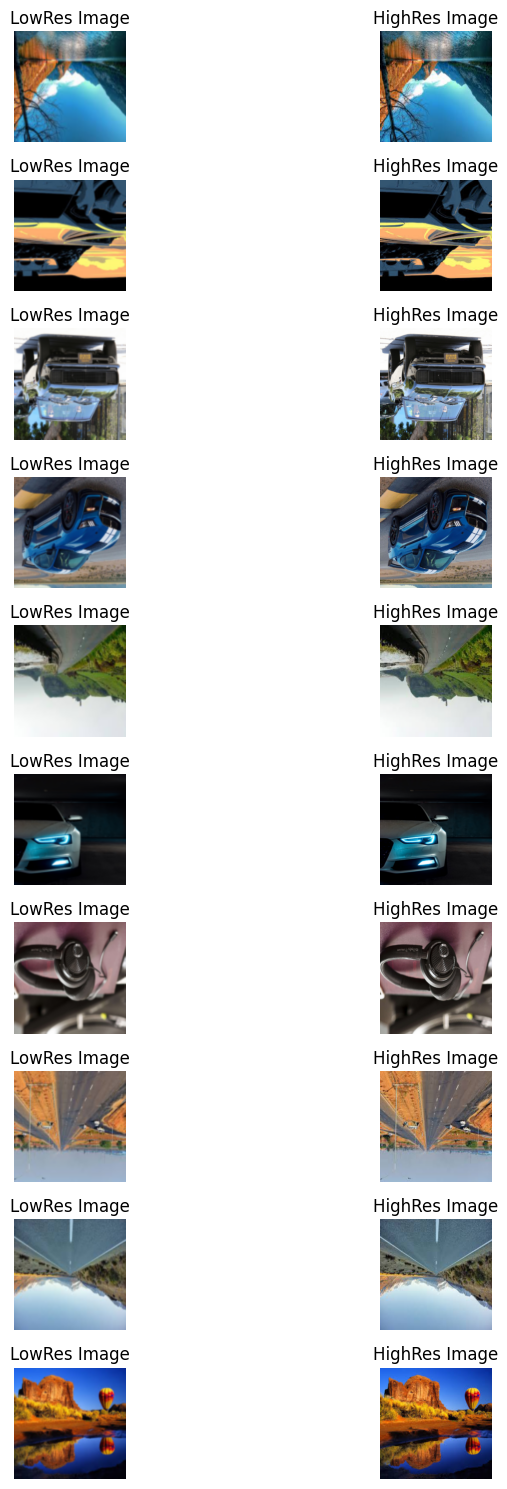

In [18]:
num_images_to_plot = 10
fig, axes = plt.subplots(num_images_to_plot, 2, figsize=(10, 15))

for i, (lowres, highres) in enumerate(dataloader):
    for j in range(num_images_to_plot):
        lo = lowres[j].permute(1, 2, 0).numpy()
        hi = highres[j].permute(1, 2, 0).numpy()
        
        # Plot noisy image
        axes[j, 0].imshow(lo)
        axes[j, 0].set_title('LowRes Image')
        axes[j, 0].axis('off')
        
        # Plot original image (target)
        axes[j, 1].imshow(hi)
        axes[j, 1].set_title('HighRes Image')
        axes[j, 1].axis('off')
        
    break  # Stop after first batch for demonstration

plt.tight_layout()
# plt.Arrowshow()

In [19]:
class DoubleConv(nn.Module):
    
    def __init__(self, in_channels,out_channels):
        
        super().__init__()
        
        self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1), #we're preserving input height and width
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1), #we're preserving input height and width
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )
    
    def forward(self,x):
        return self.conv(x)

In [20]:
class UNET(nn.Module):
    
    def __init__(self, in_channels=3, out_channels=3, features=[64,128,256,512,1024]):
        
        super().__init__()
        
        self.downsamples=nn.ModuleList()
        
        self.upsamples= nn.ModuleList()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        #now building the encoder
        
        for feature in features:
            self.downsamples.append(DoubleConv(in_channels, feature))
            in_channels=feature

        #the decoder
        
        for feature in reversed(features):
            self.upsamples.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.upsamples.append(DoubleConv(feature*2, feature))
            
        #bottleneck layer
        self.bottleneck= DoubleConv(features[-1], features[-1]*2)

        #final 1x1 conv to change out_channels
        self.final= nn.Conv2d(features[0], out_channels, kernel_size=1)
        
        
    def forward(self,x):
        skip_connections=[]

        for downsampler in self.downsamples:

            x = downsampler(x) #this is the output of each downsampling layer
            skip_connections.append(x)
            x= self.pool(x)

        x= self.bottleneck(x) 

        skip_connections= skip_connections[::-1]

        for i in range(0, len(self.upsamples), 2):

            x= self.upsamples[i](x) # this is the conv transpose layer
            skipped= skip_connections[i//2]

            concat_skipped= torch.cat((skipped,x),dim=1)

            x=self.upsamples[i+1](concat_skipped) #this is the double conv layer

        return self.final(x)

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
torch.manual_seed(42)

model = UNET().to(device)

x = torch.randn(1, 3, 256, 256).to(device)
    
output = model(x)

print("Final output size:", output.size())

Final output size: torch.Size([1, 3, 256, 256])


In [23]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

124386371

## VGG Loss

In [24]:
vgg = torchvision.models.vgg16(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 181MB/s] 


In [25]:
class VGGPerceptualLoss(nn.Module):
    """
    Calculate the perceptual loss between two images using VGG feature maps.

    This class takes two images/feature maps, computes their respective VGG feature maps at specified layers,
    and calculates the Mean Squared Error (MSE) loss between these feature maps.

    Args:
        feature_extractor (function): A feature extractor used to extract feature maps from input images.
        diction (dict): A dictionary specifying the layers from which feature maps are extracted.
                       Keys are layer numbers and values are corresponding layer sequences in the
                       feature extractor network.
        criterion (torch.nn.modules.loss) : The loss function for inter-layer loss.
        lambdas (dict) : The dictionary that stores the weights for weighted addition of losses.

    Methods:
        forward(x, y):
            Computes the perceptual loss between two images.

    """
    def __init__(self, feature_extractor, diction, criterion, lambdas):
        super(VGGPerceptualLoss, self).__init__()
        self.feature_extractor = feature_extractor
        self.diction = diction
        self.criterion = criterion
        self.lambdas = lambdas

    def forward(self, x, y):
        x_features = self.feature_extractor(x,self.diction)
        y_features = self.feature_extractor(y,self.diction)
#         print(len(x_features), len(y_features))
        loss = 0
        for layer_name,_ in self.diction.items():
            x_feat = x_features[layer_name]
            y_feat = y_features[layer_name]
            
            loss += self.lambdas[layer_name] * self.criterion(x_feat, y_feat)        
        return loss


In [26]:
features = list(vgg.features.children())[:28]
features = nn.Sequential(*features)
layers = {'6':'6','15':'15','27':'27'}
vgg_feature_extractor = {'6': features[:7].to(device), '15': features[7:16].to(device), '27': features[16:].to(device)}
lambdas = {'6': 0.3, '15': 0.3, '27': 0.4}
features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [27]:
def feature_extractor(x, dic):
    """
    Takes a torch tensor x as input and passes them through the corresponding layers
    in the dictionary.
    
    Args:
        x (torch.Tensor) : The input tensor.
        dic (dict) : The layers of the VGG Network saved as values to corresponding layer
                    names as keys.
    
    Returns:
        features (dict) : Keys = Layer names (str), Values = Extracted tensors (torch.Tensor)
    """
    features = {}
    for name, sequence in dic.items():
        x= sequence(x)
        features[name] = x
    
    return features   

In [28]:
criterion_mse = nn.MSELoss()

vgg_tester= VGGPerceptualLoss(feature_extractor, vgg_feature_extractor, criterion_mse,lambdas)

In [29]:
rand1 = torch.rand(8, 3, 256, 256).to(device)
rand2= torch.rand(8,3,256,256).to(device)

In [31]:
vgg_loss= vgg_tester.forward(highres[0].to(device), highres[0].to(device))
print(type(vgg_loss), vgg_loss)

<class 'torch.Tensor'> tensor(0., device='cuda:0', grad_fn=<AddBackward0>)


## Training Loop

In [61]:
criterion = nn.MSELoss() #
criterion_vgg = VGGPerceptualLoss(feature_extractor, vgg_feature_extractor, criterion_mse,lambdas).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002)

Epoch [1][1,     1] loss: 0.006049
###################[1,    21] loss: 0.022160
###################[1,    41] loss: 0.022086
#

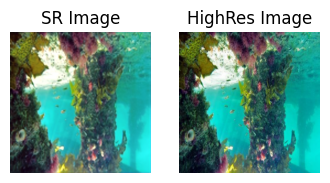

Epoch [2][2,     1] loss: 0.000786
###################[2,    21] loss: 0.020985
###################[2,    41] loss: 0.025801
#

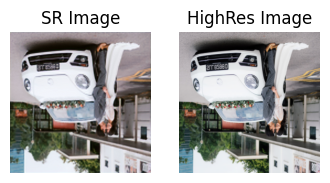

Epoch [3][3,     1] loss: 0.004447
###################[3,    21] loss: 0.016302
###################[3,    41] loss: 0.024189
#

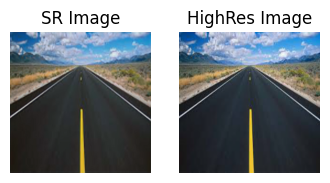

Epoch [4][4,     1] loss: 0.000630
###################[4,    21] loss: 0.017208
###################[4,    41] loss: 0.026883
#

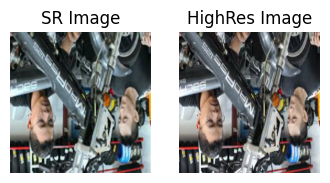

Epoch [5][5,     1] loss: 0.000688
###################[5,    21] loss: 0.025083
###################[5,    41] loss: 0.017775
#

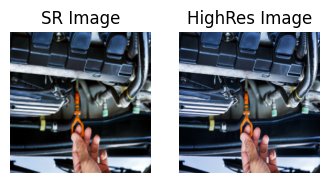

Finished Training


In [85]:
num_epochs = 5 #15

for epoch in range(num_epochs):
    running_loss = 0.0
    print(f"Epoch [{epoch+1}]", end = '')
    for i, (lowres, highres) in enumerate(dataloader):
        
        optimizer.zero_grad()
        
        outputs = model(lowres.to(device))
        
        loss =   4*criterion(outputs, highres.to(device)) #+ criterion_vgg(outputs, highres.to(device))# VGGLoss + 3 MSE
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 20 == 0:  # Print every 20 mini-batches
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
        else:
            print("#", end='')
    
    with torch.no_grad():
        fig, axes = plt.subplots(1, 2, figsize=(4, 6))
        for j in range(num_images_to_plot):
            # Plot noisy image
            axes[ 0].imshow(outputs[j].cpu().detach().numpy().transpose(1, 2, 0))
            axes[ 0].set_title('SR Image')
            axes[ 0].axis('off')

            # Plot original image (target)
            axes[ 1].imshow(highres[j].cpu().detach().numpy().transpose(1, 2, 0))
            axes[ 1].set_title('HighRes Image')
            axes[ 1].axis('off')
    plt.show()
    

print('Finished Training')

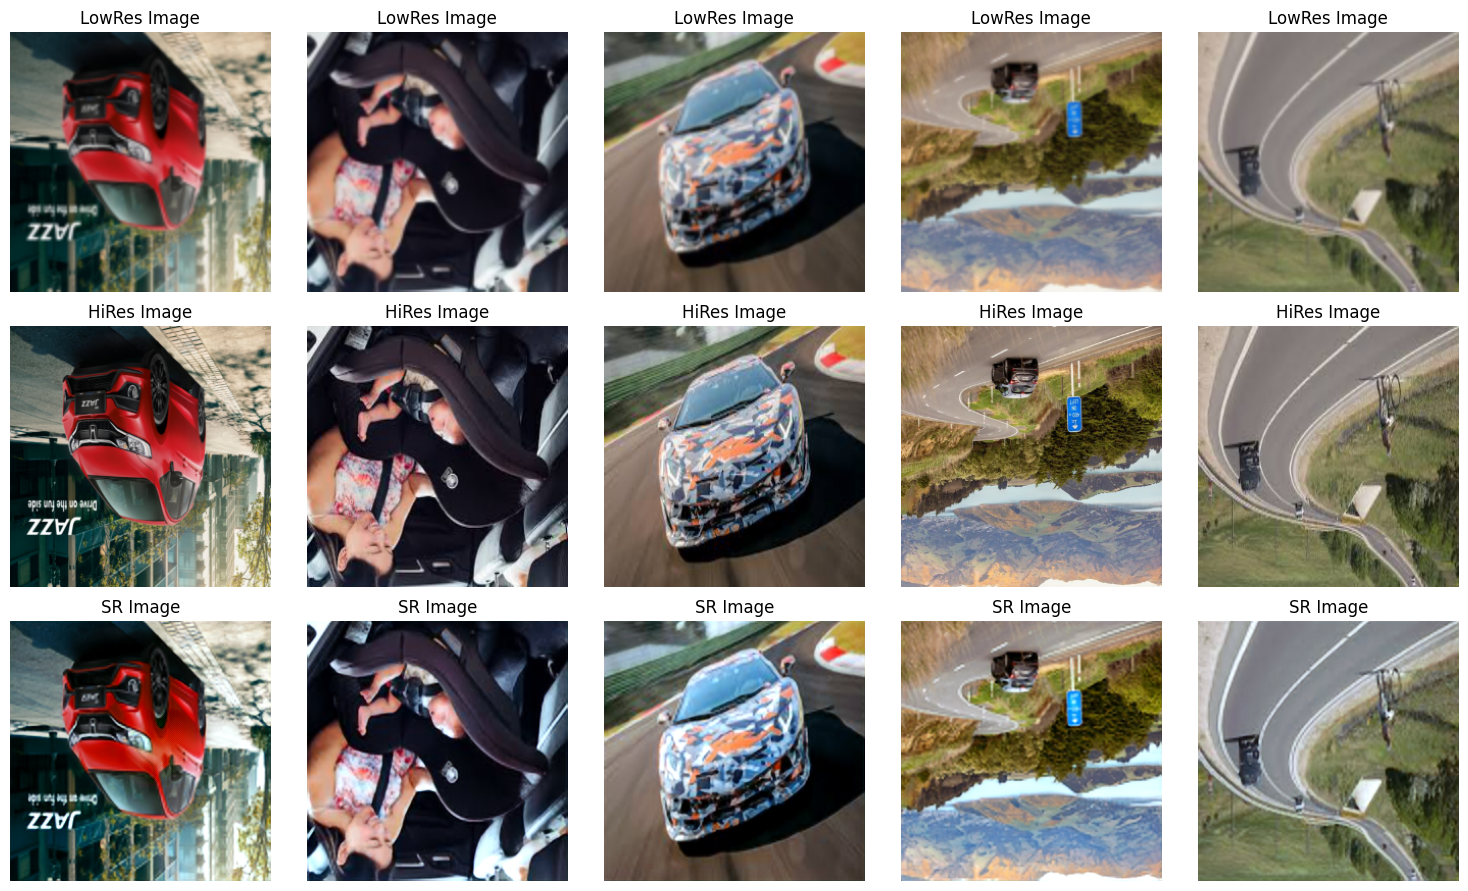

In [86]:
# Set the model to evaluation mode
# model.eval()

# Get a batch of data from the train set
batch = next(iter(dataloader))

# Extract noisy images from the batch
lowres = batch[0][:5].to(device)  # Select the first 5 images in the batch
highres = batch[1][:5].to(device)  # Corresponding original images

# Generate denoised images using the model
with torch.no_grad():
    srimages = model(lowres)
    srimages = srimages.view(-1, 3, 256, 256)  # Reshape to match the original image size

# Convert torch tensors to numpy arrays
lowres = lowres.cpu().numpy()
highres = highres.cpu().numpy()
srimages = srimages.cpu().numpy()

# Plot the images
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))

for i in range(5):
    # Plot noisy images
    axes[0, i].imshow(np.transpose(lowres[i], (1, 2, 0)))
    axes[0, i].set_title('LowRes Image')
    axes[0, i].axis('off')
    
    # Plot original images
    axes[1, i].imshow(np.transpose(highres[i], (1, 2, 0)))
    axes[1, i].set_title('HiRes Image')
    axes[1, i].axis('off')
    
    # Plot denoised images
    axes[2, i].imshow(np.transpose(srimages[i], (1, 2, 0)))
    axes[2, i].set_title('SR Image')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

In [87]:
#saving model weights
weights_dir = "/kaggle/working/"
model_weights_path = os.path.join(weights_dir, 'UNETlatest.pth')
torch.save(model.state_dict(), model_weights_path)


In [88]:
from IPython.display import FileLink, FileLinks

In [89]:
FileLinks('/kaggle/working') #lists all downloadable files on server

/kaggle/working/
  UNETlatest.pth

In [90]:
# import torch_enhance

In [91]:
# loss= torch_enhance.losses.VGG()
# loss(lo, hi)

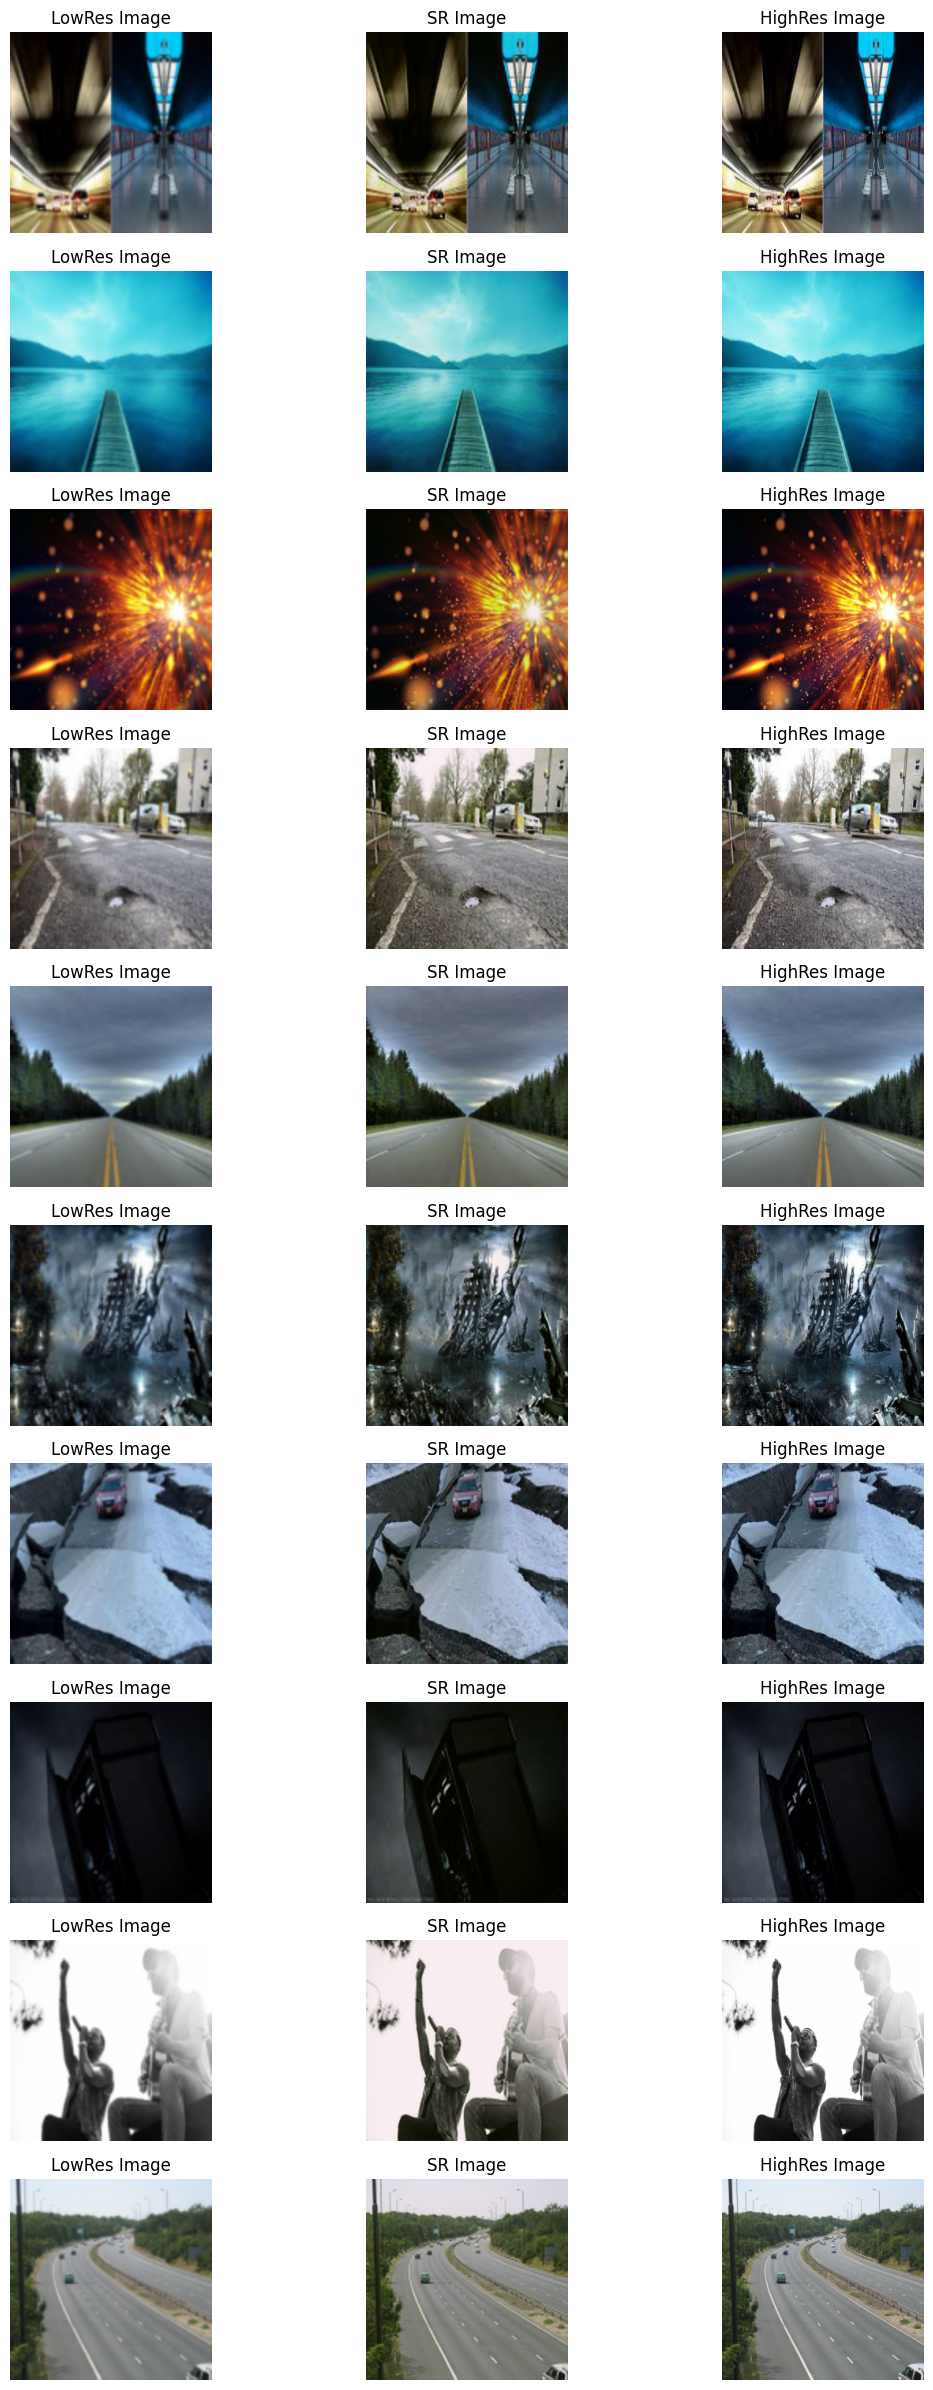

In [92]:
num_images_to_plot = 10
fig, axes = plt.subplots(num_images_to_plot, 3, figsize=(12, 24))

lowres, highres = next(iter((test_dataloader)))

lowres = lowres.to(device)
outputs = model(lowres)
for j in range(num_images_to_plot):


    lo = lowres[j].cpu().detach().permute(1, 2, 0).numpy()
    output= outputs[j].cpu().detach().permute(1,2,0).numpy()
    hi = highres[j].permute(1, 2, 0).numpy()

    # Plot noisy image
    axes[j, 0].imshow(lo)
    axes[j, 0].set_title('LowRes Image')
    axes[j, 0].axis('off')

    # Plot original image (target)
    axes[j, 1].imshow(output)
    axes[j, 1].set_title('SR Image')
    axes[j, 1].axis('off')

    axes[j, 2].imshow(hi)
    axes[j, 2].set_title('HighRes Image')
    axes[j, 2].axis('off')
    

# break  # Stop after first batch for demonstration

plt.tight_layout()
# plt.Arrowshow()